# CSC412/2506  Assignment 3: Variational Auto Encoders

In this assignment we will learn how to preform efficient inference and learning in directed graphical models with continuous latent variables.We will use stochastic variational inference with automatic differentiation (SADVI) to approximate intractible posterior distributions. 
We will implement the two gradient estimators discussed in lecture, Score Function and Reparamterization, and experimentally demonstrate their properties such as biasedness and variance. 
We will use the reparameterization gradient estimators to optimize the ELBO of our latent variable model.

You can use automatic differentiation in your code.
You may also use a machine learning framework to specify the encoder and decoder neural networks, and provide gradientent optimizers such as ADAM.
However, you may not use any probabilistic modelling elements for these frameworks.
In particular, sampling from and evaluating densities under distributions must be written by you.

In [1]:
# imports
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import numpy as np
import math
import os
import shutil
from matplotlib import pyplot as plt
from data import load_mnist, show_images_plot

%load_ext autoreload
%autoreload 2

# Implementing the VAE

In this assignment we will implement and investigate the Variational Auto Encoder on Binarized MNIST digits detailed in [Auto-Encoding Bariational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). Before starting, read this paper. In particular, we will implement model as described in Appendix C.

## Load and Prepare Data

Load the MNIST dataset, binarize the images, split into a training dataset of 10000 images and a test set of 10000 images. Also partition the training set into minibatches of size M=100.

In [2]:
# You may use the script provided in A2 or dataloaders provided by framework
N_data, train_images, train_labels, test_images, test_labels = load_mnist()

class MNISTDataset(Dataset):
    def __init__(self, images):
        super().__init__()
        images = images.astype(np.float32)
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self, item):
        image = self.images[item]
        image = torch.from_numpy(image)
        return image

batch_size = 100
train_set = MNISTDataset(train_images)
test_set = MNISTDataset(test_images)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=2)

## Distributions

Implement code to sample from and evaluate the log-pdf of diagonal multivariate gaussians $\mathcal{N}(x|\mu, \sigma I)$ and Bernoulli distributions. For sampling from these distributions, you have access to samples from uniform and unit Gaussians, (`rand` and `randn`). Make sure you test you've implemented these correctly by comparing to standard packages!

In [3]:
# sampler from Diagonal Gaussian x~N(μ,σI) (hint: use reparameterization trick here)
def sample_gaussian(mu, sigma):
    eps = torch.randn(mu.shape)
    return mu + sigma * eps

# sampler from Bernoulli
def sample_bernoulli(theta):
    return (torch.rand(theta.shape) <= theta).float()

# log-pdf of x under Diagonal Gaussian N(x|μ,σI)
def logpdf_gaussian(x, mu, sigma):
    return (-0.5*torch.log(2*math.pi*sigma**2) - 0.5*((x - mu)/sigma)**2).sum(dim=1)

# log-pdf of x under Bernoulli 
def logpdf_bernoulli(x, theta):
    return (x * torch.log(theta) + (1 - x) * torch.log(1 - theta)).sum(dim=1)

## Defining Model Architecture

Implement the model as defined in Appendix C. The MLPs will have a single hidden layer with Dh=500 hidden units. The dimensionality of the latent space will be Dz=2 for visualization purposes later.

Note that the output of the encoder will be $[\mu,\log\sigma]$. Why not ouput $\sigma$ directly? Keep this in mind when you sample from the distribution using your Diagonal Gaussian sampler.

In [4]:
# Set latent dimensionality=2 and number of hidden units=500.

# Define MLP for recognition model / "encoder"
# Provides parameters for q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, n_hidden):
        super().__init__()
        self.hidden = nn.Linear(784, n_hidden)
        self.mu = nn.Linear(n_hidden, z_dim)
        self.logsigma = nn.Linear(n_hidden, z_dim)
    def forward(self, x):
        h = torch.tanh(self.hidden(x))
        return self.mu(h), self.logsigma(h)
encoder = Encoder(z_dim=2, n_hidden=500)
encoder.eval()

# Define sample from recognition model
# Samples z ~ q(z|x)
def sample_z(mu, logsigma):
    return sample_gaussian(mu, torch.exp(logsigma))

# Define MLP for generative model / "decoder"
# Provides parameters for distribution p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, n_hidden):
        super().__init__()
        self.hidden = nn.Linear(z_dim, n_hidden)
        self.theta = nn.Linear(n_hidden, 784)
    def forward(self, z):
        h = torch.tanh(self.hidden(z))
        return torch.sigmoid(self.theta(h))
decoder = Decoder(z_dim=2, n_hidden=500)
decoder.eval()

Decoder(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (theta): Linear(in_features=500, out_features=784, bias=True)
)

## Variational Objective

Here we will use the log-pdfs, the encoder, gaussian sampler, and decoder to define the Monte Carlo estimator for the mean of the ELBO over the minibatch.

In [5]:
# log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
def log_q_zgivenx(z, mu, logsigma):
    return logpdf_gaussian(z, mu, torch.exp(logsigma))

# log_p_z(z) log probability of z under prior
def log_p_z(z):
    return logpdf_gaussian(z, torch.zeros(z.shape), torch.ones(z.shape))

# log_p(x|z) - conditional probability of data given latents.
def log_p_xgivenz(x, theta):
    return logpdf_bernoulli(x, theta)

# Monte Carlo Estimator of mean ELBO with Reparameterization over M minibatch samples.
# This is the average ELBO over the minibatch
# Unlike the paper, do not use the closed form KL between two gaussians,
# Following eq (2), use the above quantities to estimate ELBO as discussed in lecture
def elbo(x):
    mu, logsigma = encoder(x)
    z = sample_z(mu, logsigma)
    theta = decoder(z)
    return (log_p_xgivenz(x, theta) + log_p_z(z) - log_q_zgivenx(z, mu, logsigma)).mean()

## Optimize with Gradient Descent

Minimize the -ELBO with ADAM optimizer. You may use the optimizer provided by your framework

In [6]:
# Load Saved Model Parameters (if you've already trained)
def load_model(model, save_path):
    if not os.path.exists(save_path):
        return
    model.load_state_dict(torch.load(save_path, map_location=lambda storage, loc: storage))
load_model(encoder, 'saved_models/encoder.pth')
load_model(decoder, 'saved_models/decoder.pth')

In [59]:
# Set up ADAM optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

# Train for ~200 epochs (1 epoch = all minibatches in traindata)
shutil.rmtree('logs', ignore_errors=True)
writer = SummaryWriter('logs')
metric_freq = 50
running_loss = 0.0
print('Beginning training')
encoder.train()
decoder.train()
for epoch in range(1, 201):
    for batch, x in enumerate(train_loader):
        step_num = (epoch - 1) * len(train_loader) + batch
        loss = -elbo(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss / metric_freq
        if (step_num + 1) % print_freq == 0:
            writer.add_scalar('-ELBO', running_loss, step_num)
            running_loss = 0.0
print('Finished training')
encoder.eval()
decoder.eval()
writer.close()

Beginning training
Finished training


In [60]:
# Save Optimized Model Parameters
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
save_model(encoder, 'saved_models/encoder.pth')
save_model(decoder, 'saved_models/decoder.pth')

## Report ELBO on Training and Test Set

In [7]:
with torch.no_grad():

    # ELBO on training set
    running_elbo = 0.0
    for x in train_loader:
        loss = elbo(x)
        running_elbo += loss / len(train_loader)
    print('Training mean ELBO: %g' % running_elbo.item())

    # ELBO on test set
    running_elbo = 0.0
    for x in test_loader:
        loss = elbo(x)
        running_elbo += loss / len(test_loader)
    print('Test mean ELBO: %g' % running_elbo.item())

Training mean ELBO: -133.735
Test mean ELBO: -156.081


# Numerically Computing Intractable Integrals

## Numerical Integration over Latent Space

Since we chose a low dimensional latent space, we are able to perform [numerical integration](https://en.wikipedia.org/wiki/Riemann_sum) to evaluate integrals which are intractible in higher dimension. 

For instance, we will use this to integrate over the latent space. e.g. the $$p(z|x) = \frac{p(x|z)*p(z)}{p(x)}= \frac{p(x|z)*p(z)}{\int p(x|z)*p(z) dz}$$

We want to numerically compute that integral. However, since we are parameterizing $\log p(x|z)$ and $\log p(z)$ we will have
$$\log p(z|x) = \log p(x|z) + \log p(z) - \log \int \exp [\log p(x|z)+ \log p(z)] dz$$

You will write code which computes $\log \int \exp \log f(z) dz$ given an equally spaced  grid of $\log f(z)$s as input.
Note that if we approximate that integral with a numerical sum, in order for it to be numerical we will need `logsumexp`.

In [8]:
# Implement log sum exp
# **just going to use the pytorch implementation, since everything is already in pytorch...

# Implement stable numerical integration 
# over a 2d grid of equally spaced (delta_z) evaluations logf(x)
def log_integral(grid, delta_z, logf):
    return torch.logsumexp(logf(grid), dim=0) + 2*math.log(delta_z)

## Compare Numerical Log-Likelihood to ELBO

We can use the numerical integration to compute the log-likeihood of a element in our dataset under our model. We can then compare the numerical integration to the estimate given by the ELBO.

In [9]:
# Define the delta_z to be the spacing of the grid  (I used delta_z = 0.1)
delta_z = 0.1

# Define a grid of delta_z spaced points [-4,4]x[-4,4]
z_grid = torch.linspace(-4, 4, steps=int(8/delta_z)+1)
z_grid = torch.meshgrid([z_grid, z_grid])
z_grid = torch.stack(z_grid)
z_grid = z_grid.view(2, -1).transpose(1, 0).contiguous()

# Sample an x from the data to evaluate the likelhiood
x = train_set[:1]

# Compute log_p(x|z)+log_p(z) for every point on the grid
def logf(z):
    with torch.no_grad():
        theta = decoder(z)
    return log_p_xgivenz(x, theta) + log_p_z(z)

# Using your numerical integration code
# integrate log_p(x|z)+log_p(z) over z to find log_p(x)
log_p_x = log_integral(z_grid, delta_z, logf)
print('log_p(x): %g' % log_p_x)

# Check that your numerical integration is correct 
# by integrating log_p(x|z)+log_p(z) - log_p(x)
# If you've successfully normalized this should integrate to 0 = log 1
def logf_test(z):
    with torch.no_grad():
        theta = decoder(z)
    return log_p_xgivenz(x, theta) + log_p_z(z) - log_p_x
delta = log_integral(z_grid, delta_z, logf_test)
if delta < 1e-5:
    print('Numerical integration code correct')
else:
    print('Numerical integration code incorrect')

# Now compute the ELBO on x
e = elbo(x).item()
print('ELBO(x): %g' % e)

# Try this for multiple samples of x
# note that the ELBO is a lower bound to the true log_p(x)!
mean_delta = 0.0
for i in range(1000, 1101):
    x = train_set[i:i+1]
    log_p_x = log_integral(z_grid, delta_z, logf)
    e = elbo(x).item()
    mean_delta += (log_p_x - e).item() / 100
print('Mean difference between ELBO and log_p(x): %g' % mean_delta)

log_p(x): -182.709
Numerical integration code correct
ELBO(x): -186.471
Mean difference between ELBO and log_p(x): 1.94432


# Data Space Visualizations

In this section we will investigate our model by visualizing the distributions over data given by the generative model, samples from these distributions, and reconstructions of the data.

In [10]:
# Write a function to reshape 784 array into a 28x28 image for plotting
def to_numpy_image(x):
    return x.view(-1, 28, 28).numpy()

## Samples from the generative model

Here you will sample from the generative model using ancestral sampling. 

* First sample a z from the prior. 
* Then use the generative model to parameterize a bernoulli distribution over x given z. Plot this distribution.
* Then sample x from the distribution. Plot this sample.

Do this for 10 samples z from the prior.

Concatenate all your plots into one 10x2 figure where the first column is the distribution over x and the second column is a sample from this distribution. Each  row will be a new sample from the prior.

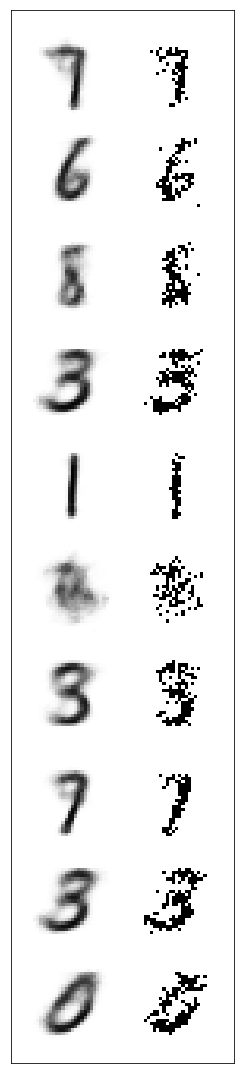

In [11]:
# Sample 10 z from prior
z = sample_gaussian(torch.zeros(10, 2), torch.ones(10, 2))

# For each z, plot p(x|z)
with torch.no_grad():
    theta = decoder(z)

# Sample x from p(x|z) 
x = sample_bernoulli(theta)

# Concatenate plots into a figure
theta = to_numpy_image(theta)
x = to_numpy_image(x)
images = np.stack([theta, x], axis=1)
show_images_plot(images, size=(4, 20))

## Reconstructions of data

Here we will investigate the VAEs ability to reconstruct 10 inputs from the data. For each input ou will

* Plot the input $x$
* Use the recognition network to encode $x$ to the parameters for a distribution $q(z|x)$
* Sample $z \sim q(z|x)$
* Use the generative model to decode to the parameters for distribution $p(x|z)$. Plot this
* Sample $\tilde x \sim p(x|z)$. Plot this

Then you will concatenate all your plots into a 10x3 figure where the first column is the input data, the second column is the distribution over x, the third column is a reconstruction of the input. Each row will be a new sample from the data.

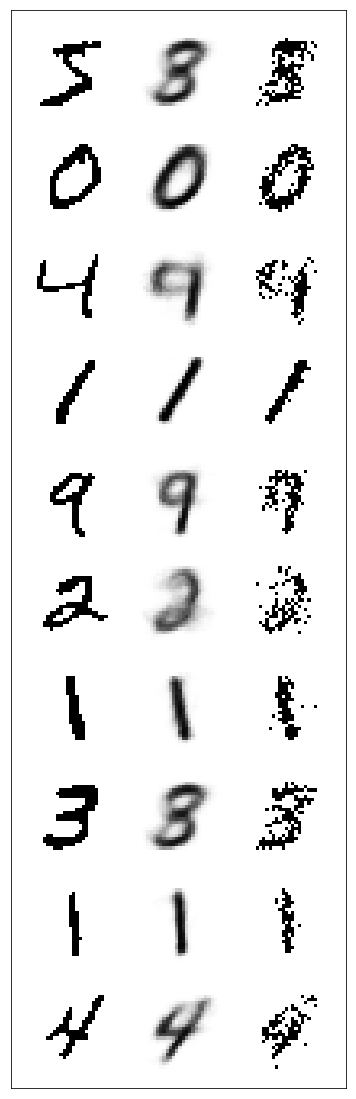

In [12]:
# Sample 10 xs from the data, plot.
x = train_set[:10]

# For each x, encode to distribution q(z|x)
with torch.no_grad():
    mu, logsigma = encoder(x)

# For each x, sample distribution z ~ q(z|x)
z = sample_z(mu, logsigma)

# For each z, decode to distribution p(x̃|z), plot.
with torch.no_grad():
    theta = decoder(z)

# For each x, sample from the distribution x̃ ~ p(x̃|z), plot.
x_rec = sample_bernoulli(theta)

# Concatenate all plots into a figure.
x = to_numpy_image(x)
theta = to_numpy_image(theta)
x_rec = to_numpy_image(x_rec)
images = np.stack([x, theta, x_rec], axis=1)
show_images_plot(images, size=(6, 20))

# Latent Space Visualizations

In this section we will investigate our model by visualizing the latent space through various methods. These will include encoding the data, decoding along a grid, and linearly interpolating between encdoded data.

## Latent embedding of data

One way to understand what is represented in the latent space is to consider where it encodes elements of the data. Here we will produce a scatter plot in the latent space, where each point in the plot will be the mean vector for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot by the class label for the input data. 

Hopefully our latent space will have learned to distinguish between elements from different classes, even though we never provided class labels to the model!

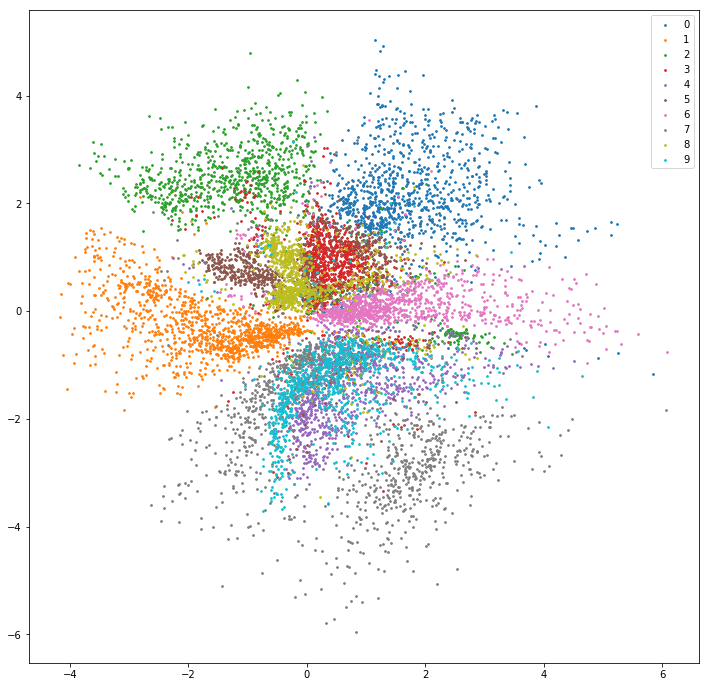

In [13]:
# Encode the training data
with torch.no_grad():
    mu, _ = encoder(train_set[:])

# Take the mean vector of each encoding
# mu already encodes the mean vector...

# Plot these mean vectors in the latent space with a scatter
# Colour each point depending on the class label
mu = mu.numpy()
mu = [mu[train_labels == i] for i in range(10)]
f, ax = plt.subplots()
f.set_size_inches(12, 12)
plots = [ax.scatter(m[:, 0], m[:, 1], label='%d' % i, s=3) for i, m in enumerate(mu)]
plt.legend(handles=plots)

## Decoding along a lattice

We can also understand the "learned manifold" by plotting the generative distribution $p(x|z)$ for each point along a grid in the latent space. We will replicate figure 4b in the paper.

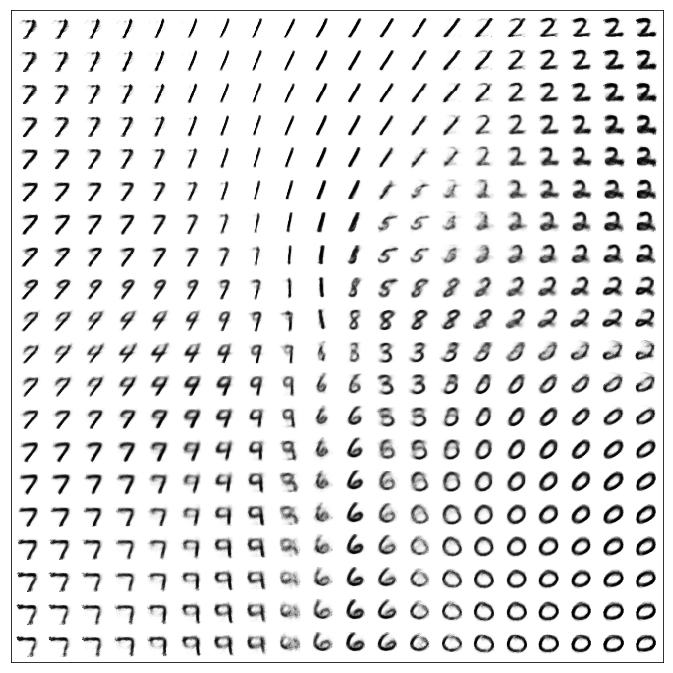

In [14]:
# Create a 20x20 equally spaced grid of z's
# (use the  previous figure to help you decide appropriate bounds for the grid)
z_grid = torch.linspace(-4, 4, steps=20)
z_grid = torch.meshgrid([z_grid, z_grid])
z_grid = torch.stack(z_grid)
z_grid = z_grid.view(2, -1).transpose(1, 0).contiguous()

# For each z on the grid plot the generative distribution over x
with torch.no_grad():
    theta = decoder(z_grid)

# concatenate these plots to a lattice of distributions
theta = to_numpy_image(theta)
theta = theta.reshape(20, 20, 28, 28)
show_images_plot(theta, size=(12, 12))

## Interpolate between two classes

A common technique to assess latent representations is to interpolate between two points.

Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.

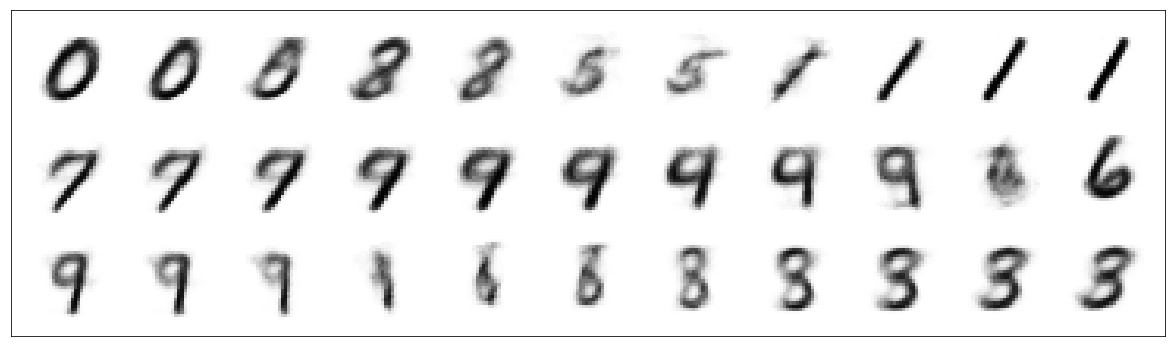

In [15]:
# Function which gives linear interpolation z_α between za and zb
def interpolate_z(za, zb, alpha):
    return (1 - alpha) * za + alpha * zb

# Sample 3 pairs of data with different classes
class_samples = [0, 1, 7, 6, 9, 3]    # 0->1, 7->6, 9->3
sample_indices = [train_labels.tolist().index(c) for c in class_samples]
data_samples = train_set[sample_indices]
data_pairs = data_samples.split(2)

# Encode the data in each pair, and take the mean vectors
with torch.no_grad():
    mu_pairs = [encoder(pair)[0] for pair in data_pairs]

# Linearly interpolate between these mean vectors
alphas = [0.1*i for i in range(11)]
mu_pair_interpolations = [torch.stack([interpolate_z(mu[0], mu[1], a) for a in alphas]) for mu in mu_pairs]

# Along the interpolation, plot the distributions p(x|z_α)
with torch.no_grad():
    theta_pair_interpolations = [decoder(mu) for mu in mu_pair_interpolations]

# Concatenate these plots into one figure
theta_pair_interpolations = [to_numpy_image(t) for t in theta_pair_interpolations]
theta_pair_interpolations = np.stack(theta_pair_interpolations)
show_images_plot(theta_pair_interpolations, size=(22, 6))

# Posteriors and Stochastic Variational Inference

Here we will use numerical integration to plot the "true" posterior $p(z|x)$ which is generally intractable. We will compare the intractable true posterior to the variational approximate posterior given by the recognition model $q(z|x)$.

Then we will use the generative model to perform inference other inference tasks. In particular, we will see that the purpose of the encoder was only to make training the generative model tractable, and that we can do inference using the generative model completely without the encoder. To illustrate this we will perform the inference task of producing a generative distribution over the bottom half of the digit conditioned on the top half. We will achieve this with stochastic variational inference.

## Plotting Posteriors 

Here we will plot the true posterior by evaluating $\log p(x|z)+\log p(z)$ on an equally spaced grid over z then numerically integrating over this grid to find the log-normalizer $\log p(x)$. This will give us the intractable true posterior $p(z|x)$.

Then we will compare the true posterior to the approximate posterior given by the recognition model $q(z|x)$. Does the recognition model produce a good approximate posterior to the intractable true posterior?

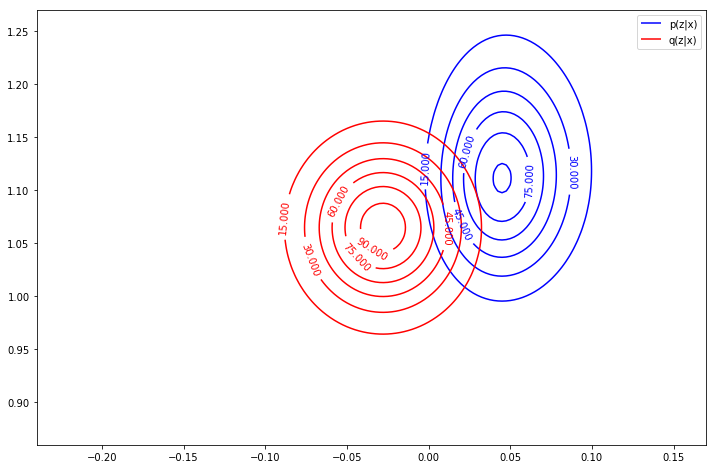

In [16]:
# Sample an element x from the dataset to plot posteriors for
x = train_set[:1]

# Define a grid of equally spaced points in z
# The grid needs to be fine enough that the plot is nice
# To keep the integration tractable 
# I reccomend centering your grid at the mean of q(z|x)
delta_z = 0.0025
steps = int(0.41/delta_z)+1
z_grid_x = torch.linspace(-0.24, 0.17, steps=steps)
z_grid_y = torch.linspace(0.86, 1.27, steps=steps)
z_grid = torch.meshgrid([z_grid_x, z_grid_y])
z_grid = torch.stack(z_grid)
z_grid = z_grid.view(2, -1).transpose(1, 0).contiguous()

# Evaluate log_p(x|z) + log_p(z) for every z on the grid
def logf(z):
    with torch.no_grad():
        theta = decoder(z)
    return log_p_xgivenz(x, theta) + log_p_z(z)

# Numerically integrate log_p(x|z) + log_p(z) to get log_p(x)
log_p_x = log_integral(z_grid, delta_z, logf)

# Produce a grid of normalized log_p(z|x)
log_p_zgivenx = logf(z_grid) - log_p_x

# Plot the contours of p(z|x) (note, not log)
# DOING PLOTS AT THE END
p_zgivenx = torch.exp(log_p_zgivenx)
p_zgivenx = p_zgivenx.view(steps, steps).numpy()

# Evaluate log_q(z|x) recognition network for every z on grid
# DOING PLOTS AT THE END
with torch.no_grad():
    mu, logsigma = encoder(x)
q_zgivenx = torch.exp(log_q_zgivenx(z_grid, mu, logsigma))
q_zgivenx = q_zgivenx.view(steps, steps).numpy()

# Plot the contours of q(z|x) on previous plot
f, ax = plt.subplots()
f.set_size_inches(12, 8)
z = z_grid.numpy()
xs = z[:, 0].reshape(steps, steps)
ys = z[:, 1].reshape(steps, steps)
contour_p = ax.contour(xs, ys, p_zgivenx, colors='blue')
contour_q = ax.contour(xs, ys, q_zgivenx, colors='red')
ax.clabel(contour_p, inline=1, fontsize=10)
ax.clabel(contour_q, inline=1, fontsize=10)
hq, _ = contour_q.legend_elements()
hp, _ = contour_p.legend_elements()
ax.legend([hp[0], hq[0]], ['p(z|x)', 'q(z|x)'])

## True posterior for top of digit

In this question we will plot the "true" posterior given only the top of the image, $p(z|x_{top})$. 

Realize that the generative model gives a Bernoulli distribution over each pixel in the image. We can easily evaluate the likelihood of only the top of an image by evaluating under only those corresponding dimensions of the generative model.

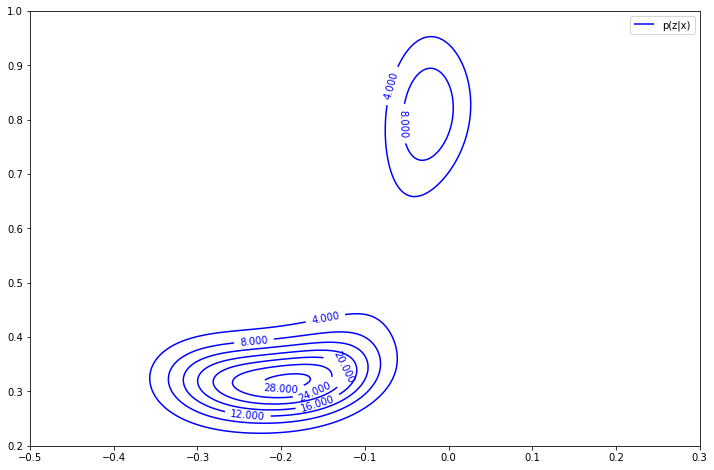

In [17]:
# Function which returns only the top half of a 28x28 array
# This will be useful for plotting, as well as selecting correct bernoulli params
def top_half(x):
    return x[:, :392]

# log_p(x_top | z) (hint: select top half of 28x28 bernoulli param array)
def log_p_xtopgivenz(x_top, z):
    with torch.no_grad():
        theta = decoder(z)
    return logpdf_bernoulli(x_top, top_half(theta))

# Sample an element from the data set and take only its top half: x_top
x_top = top_half(train_set[:1])

# Define a grid of equally spaced points in z
delta_z = 0.0025
steps = int(0.8/delta_z)+1
z_grid_x = torch.linspace(-0.5, 0.3, steps=steps)
z_grid_y = torch.linspace(0.2, 1.0, steps=steps)
z_grid = torch.meshgrid([z_grid_x, z_grid_y])
z_grid = torch.stack(z_grid)
z_grid = z_grid.view(2, -1).transpose(1, 0).contiguous()

# Evaluate log_p(x_top | z) + log_p(z) for every z on grid
def logf(z):
    return log_p_xtopgivenz(x_top, z) + log_p_z(z)

# Numerically integrate to get log_p(x_top)
log_p_xtop = log_integral(z_grid, delta_z, logf)

# Normalize to produce grid of log_p(z|x_top)
log_p_zgivenxtop = logf(z_grid) - log_p_xtop

# Plot the contours of p(z|x_top)
p_zgivenxtop = torch.exp(log_p_zgivenxtop)
p_zgivenxtop = p_zgivenxtop.view(steps, steps).numpy()
f, ax = plt.subplots()
f.set_size_inches(12, 8)
z = z_grid.numpy()
xs = z[:, 0].reshape(steps, steps)
ys = z[:, 1].reshape(steps, steps)
contour_p = ax.contour(xs, ys, p_zgivenxtop, colors='blue')
ax.clabel(contour_p, inline=1, fontsize=10)
hp, _ = contour_p.legend_elements()
ax.legend([hp[0]], ['p(z|x)'])

## Learn approximate posterior for top of digit with Stochastic Variational Inference

In this question we will see how we can use SVI to learn an approximate posterior to $p(z|x_{top})$ which we just obtained through intractable integration.

Note that we can't just use our recognition model, because our encoder doesn't know what to do with only top halfs of images. Instead, we will initialize a variational distribution $q(z) = \mathcal{N}(z| \mu,\sigma I)$ and optimize the ELBO to minimize the KL divergence between it and the true distribution.

In [18]:
# Initialize parameters μ and logσ for variational distribution q(z)
mu = nn.Parameter(data=torch.zeros(1, 2))
logsigma = nn.Parameter(data=torch.zeros(1, 2))

# Define mean ELBO over M samples z ~ q(z)
# using log_p(z), log_p(x_top | z), and q(z|x_top)
def elbo_q(x_top, mu, logsigma, m):
    mu_batch, logsigma_batch = mu.repeat(m, 1), logsigma.repeat(m, 1)
    z = sample_z(mu_batch, logsigma_batch)
    return (log_p_xtopgivenz(x_top, z) + log_p_z(z) - log_q_zgivenx(z, mu_batch, logsigma_batch)).mean()

# Loss for SVI is -1*ELBO

# Set up ADAM to optimize μ and logσ
optimizer = optim.Adam([mu, logsigma], lr=0.1)

# Optimize for a few iterations until convergence (you can use a larger stepsize here)
x_top = top_half(train_set[:1])
for i in range(10000):
    loss = -elbo_q(x_top, mu, logsigma, 100)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(loss.item())
print(mu, logsigma)

147.95742797851562
144.60284423828125
158.7805633544922
145.97537231445312
141.3963623046875
143.9989471435547
140.63050842285156
146.07119750976562
141.1551513671875
138.2891387939453
Parameter containing:
tensor([[-0.0900, -0.0490]], requires_grad=True) Parameter containing:
tensor([[ 0.0087, -0.0047]], requires_grad=True)


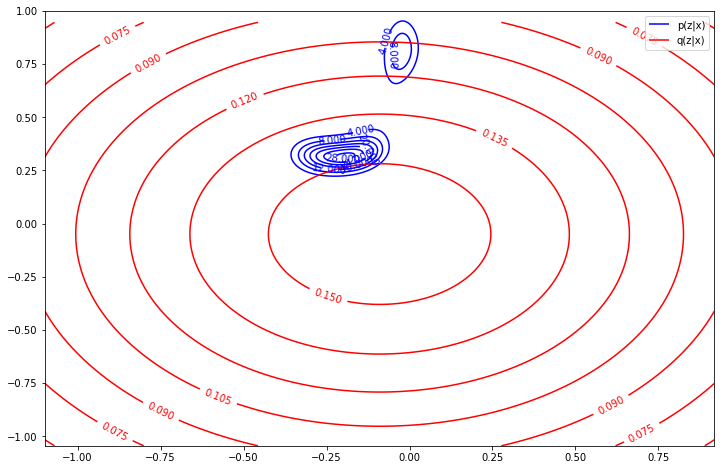

In [19]:
# On previous plot of contours of p(z|x_top) plot the optimized q(z)
delta_z = 0.005
sigma_x, sigma_y = torch.exp(logsigma)[0]
sigma_x, sigma_y = sigma_x.item(), sigma_y.item()
mu_x, mu_y = mu[0]
mu_x, mu_y = mu_x.item(), mu_y.item()
steps_x = int(sigma_x/delta_z)+1
steps_y = int(sigma_y/delta_z)+1
z_grid_x = torch.linspace(mu_x-sigma_x, mu_x+sigma_x, steps=steps_x)
z_grid_y = torch.linspace(mu_y-sigma_y, mu_y+sigma_y, steps=steps_y)
z_grid = torch.meshgrid([z_grid_x, z_grid_y])
z_grid = torch.stack(z_grid)
z_grid = z_grid.view(2, -1).transpose(1, 0).contiguous()

with torch.no_grad():
    q_z = log_q_zgivenx(z_grid, mu, logsigma)
q_z = torch.exp(q_z).view(steps_x, steps_y).numpy()
z = z_grid.numpy()
xs = z[:, 0].reshape(steps_x, steps_y)
ys = z[:, 1].reshape(steps_x, steps_y)
contour_q = ax.contour(xs, ys, q_z, colors='red')
ax.clabel(contour_q, inline=1, fontsize=10)
hq, _ = contour_q.legend_elements()
ax.legend([hp[0], hq[0]], ['p(z|x)', 'q(z|x)'])
f

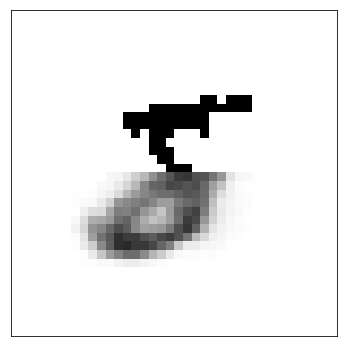

In [20]:
# Sample z ~ q(z)
with torch.no_grad():
    z = sample_z(mu, logsigma)

# Use generative model p(x|z) to produce distribution over x
with torch.no_grad():
    theta = decoder(z)

# Extract the bottom half of this generative distribution: p(x_bot| z)
p_xbot = theta[:, 392:]

# Concatenate the x_top and p(x_bot | z) and plot.
x = torch.cat([x_top, p_xbot]).reshape(1, 1, 28, 28).numpy()
show_images_plot(x, size=(6, 6))

# Investigating Gradient Estimators

In this part we will experimentally investigate the difference in variances between the gradient estimates given by the Reparameterization and Score-Function gradient estimators.

Comment on their mean and variances

Reparameterization Gradients:
Mean: 0.0153016
Standard Deviation: 0.298356

Score Function Gradients:
Mean: -0.135406
Standard Deviation: 31.151


Decoder(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (theta): Linear(in_features=500, out_features=784, bias=True)
)

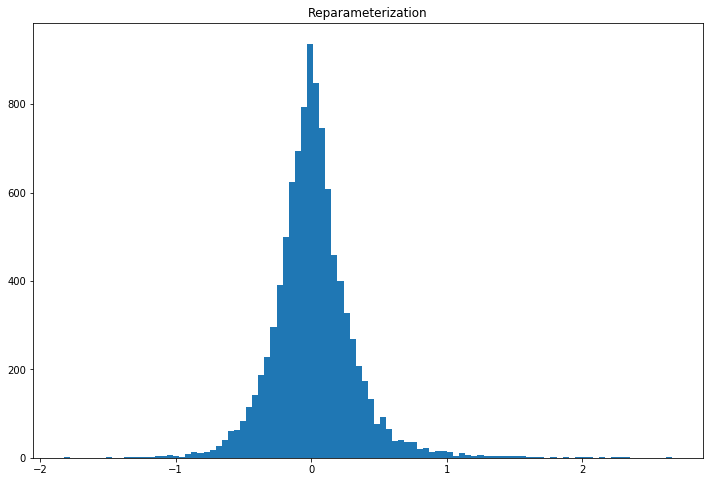

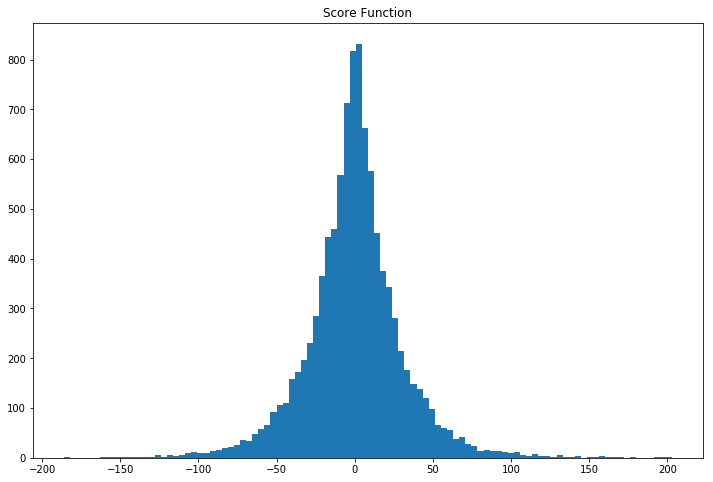

In [21]:
encoder.train()
decoder.train()

# Use Reparameterization Gradient Estimator
# to estimate gradient of mean ELBO wrt μ over M minibatch samples
# hint: this will involve just taking gradients through the code used to train
reparam_mu_grads = []
def elbo_gradmu(x):
    mu, logsigma = encoder(x)
    mu.register_hook(lambda grad: reparam_mu_grads.extend(grad[:, 0].numpy().tolist()))
    z = sample_z(mu, logsigma)
    theta = decoder(z)
    return (log_p_xgivenz(x, theta) + log_p_z(z) - log_q_zgivenx(z, mu, logsigma)).mean()
for batch, x in enumerate(train_loader):
    e = elbo_gradmu(x)
    encoder.zero_grad()
    decoder.zero_grad()
    e.backward()
reparam_mu_grads = np.array(reparam_mu_grads)
print('Reparameterization Gradients:\nMean: %g\nStandard Deviation: %g' % (reparam_mu_grads.mean(), reparam_mu_grads.std()))

# Use Score-Function Gradient Estimator
# to estimate gradient of mean ELBO wrt μ over M minibatch samples
# make sure you are not useing the reparameterization trick to sample z from q
# you should only be taking gradients through log_q(z|x), no gradients through ELBO or z
score_mu_grads = []
def score_function(x):
    mu, logsigma = encoder(x)
    mu.register_hook(lambda grad: score_mu_grads.extend(grad[:, 0].numpy().tolist()))
    z = sample_z(mu, logsigma).detach()
    theta = decoder(z)
    e = log_p_xgivenz(x, theta) + log_p_z(z) - log_q_zgivenx(z, mu, logsigma)
    e = e.detach()
    return (e * log_q_zgivenx(z, mu, logsigma)).mean()
for batch, x in enumerate(train_loader):
    s = score_function(x)
    encoder.zero_grad()
    decoder.zero_grad()
    s.backward()
score_mu_grads = np.array(score_mu_grads)
print('\nScore Function Gradients:\nMean: %g\nStandard Deviation: %g' % (score_mu_grads.mean(), score_mu_grads.std()))

# Consider the gradients wrt the first component of μ
# Produce two histograms in two different subplots
# First show the distribution of gradients given by Reparameterization estimator
# Second show the distribution of gradients given by Score Function Estimator
f, ax = plt.subplots()
f.set_size_inches(12, 8)
ax.hist(reparam_mu_grads, bins=100)
ax.set_title('Reparameterization')
f
f, ax = plt.subplots()
f.set_size_inches(12, 8)
ax.hist(score_mu_grads, bins=100)
ax.set_title('Score Function')
f

encoder.eval()
decoder.eval()

Based on these two plots, we can see that the gradients computed by the Reparameterization Estimator have a similar mean to those computed by the Score Function Estimator, but have a very different variance. Whereas the variance of the gradients using the Reparameterization Estimator is small, that of the Score Function Estimator is much larger. From this result, we can see why the reparameterization trick is preferable in terms of making learning easier.